In [28]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from tqdm import tqdm

In [3]:
dataset_1 = pd.read_csv("dataset_1.csv")
dataset_2 = pd.read_csv("dataset_2.csv")
dataset_3 = pd.read_csv("dataset_3.csv")
dataset_4 = pd.read_csv("dataset_4.csv")
dataset_5 = pd.read_csv("dataset_5.csv")
dataset_6 = pd.read_csv("dataset_6.csv")
datasets = [dataset_1, dataset_2, dataset_3, dataset_4, dataset_5, dataset_6]

## Exploratory Data Analysis

### Scatterplot

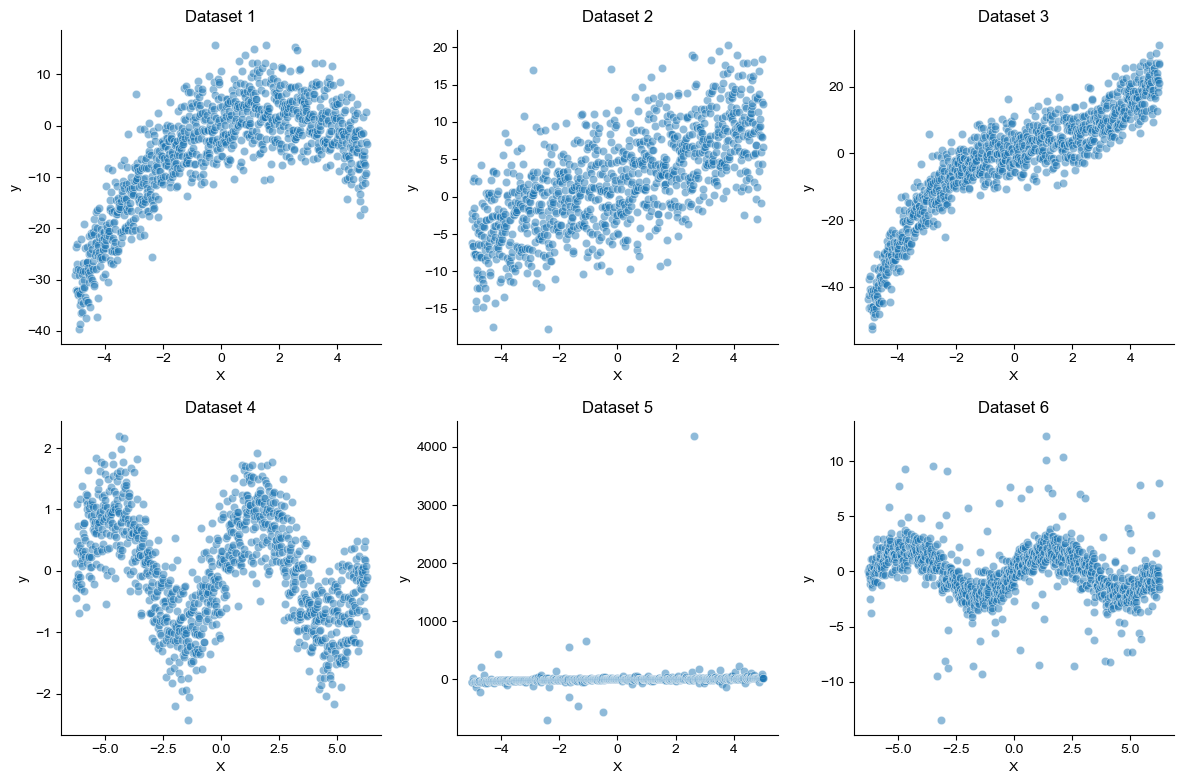

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

axes = axes.flatten()

sns.set(style="whitegrid", palette="pastel", rc={"grid.color": ".9"})

for i, (ax, data) in enumerate(zip(axes, datasets)):
    sns.scatterplot(x="X", y="y", data=data, ax=ax, alpha=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.set_title(f"Dataset {i + 1}")

# Remove the top and right spines from plot(s)
sns.despine()

plt.tight_layout()
plt.show()

Estas gráficas muestran como se distribuyen los datasets. Se puede observar la presencia de datasets con relaciones entre `X` e `y` más lineales, como dataset 2 y dataset 5, y datasets con relaciones más complejas que requerirán de mayor grado en la regresiónm polinómica, como dataset 1, 3, 4 y 6.

## 10-Fold Cross Validation

In [5]:
def train_valid_mse_cv(
    dataset: pd.DataFrame,
    degree: int,
    k_folds: int = 10,
    alpha: float = 0.0,
    regularization: str = "none",
) -> dict[str, float | Ridge | Lasso]:
    """Train a polynomial regression with a selected degree model using k-fold.

    For each alpha and fold calculates the MSE on the training and validation sets.

    Parameters
    ----------
    dataset : pd.DataFrame
        Pandas DataFrame with the dataset. It must have two columns: "X" and "y".
    degree : int
        Degree of the polynomial features.
    k_folds : int, optional
        Number of folds for the k-fold cross-validation, by default 10.
    alpha : float, optional
        Alpha value for the regularization, by default 0.0.
    regularization : str, optional
        Type of regularization to use ("none", "l1", "l2"), by default "none".

    Returns
    -------
    dict[str, float | Ridge | Lasso]
        Dictionary with the mean MSE for the training and validation
        sets from all the folds. The dictionary also contains the best model for
        the dataset.
    """
    if regularization not in ["none", "l1", "l2"]:
        raise ValueError("Regularization must be 'none', 'l1' or 'l2'.")

    mse_dict = {"mse_train": None, "mse_valid": None, "model": None}

    # Split the dataset into k folds
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    models_list = []
    mse_train_list = []
    mse_valid_list = []
    for train_index, val_index in kf.split(dataset):
        train_set = dataset.iloc[train_index]
        val_set = dataset.iloc[val_index]

        X_train = train_set[["X"]]
        y_train = train_set["y"]

        X_val = val_set[["X"]]
        y_val = val_set["y"]

        # Transform features into polynomial
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)

        # Select the model based on the regularization type
        # Apply StandardScaler to the model to normalize the features
        # and avoid numerical instability
        # High `max_iter` to avoid convergence warnings
        if regularization == "l1":
            model = make_pipeline(
                StandardScaler(), Lasso(alpha=alpha, max_iter=1000000)
            )
        elif regularization == "l2":
            model = make_pipeline(
                StandardScaler(), Ridge(alpha=alpha, max_iter=1000000)
            )
        else:
            model = make_pipeline(
                StandardScaler(), Ridge(alpha=0.0, max_iter=1000000)
            )  # Equivalent to no regularization

        # Train the model
        model.fit(X_train_poly, y_train)
        models_list.append(model)

        # Predict on the train set
        y_train_pred = model.predict(X_train_poly)

        # Predict on the validation set
        y_val_pred = model.predict(X_val_poly)

        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_valid = mean_squared_error(y_val, y_val_pred)
        mse_train_list.append(mse_train)
        mse_valid_list.append(mse_valid)

    # Calculate the mean from all the folds
    mse_dict["mse_train"] = np.mean(mse_train_list)
    mse_dict["mse_valid"] = np.mean(mse_valid_list)

    # Get the model with lowest validation error
    best_model_idx = np.argmin(mse_valid_list)
    best_model = models_list[best_model_idx]
    mse_dict["model"] = best_model

    return mse_dict

In [6]:
def train_valid_mse(
    degrees: list[int],
    datasets: list[pd.DataFrame],
    k_folds: int = 10,
    alphas: list[float] = None,
    regularization: str = "none",
) -> dict[str, dict[str, list[float]]]:
    """Train polynomial regression for each dataset and degree. Uses k-fold CV.

    Parameters
    ----------
    degrees : list[int]
        List with the degrees of the polynomial features.
    datasets : list[pd.DataFrame]
        List with the datasets.
    k_folds : int, optional
        Number of folds for the k-fold cross-validation, by default 10.
    alphas : list[float], optional
        List with the lambda (alpha in scikit-learn) regularization parameter values,
        by default None.
    regularization : str, optional
        Type of regularization to use

    Returns
    -------
    dict[str, dict[str, list[float]]]
        Dictionary with the mean squared error for the training and validation sets
        for each dataset, alpha and degree; and the model with the lowest validation
        error.
    """
    if alphas is None:
        alphas = [0.0]  # Default to no regularization if alphas is not provided

    mse_per_dataset_dict = {
        f"dataset_{i + 1}": {
            "mse_train": {alpha: [] for alpha in alphas},
            "mse_valid": {alpha: [] for alpha in alphas},
            "model": {alpha: [] for alpha in alphas},
        }
        for i in range(len(datasets))
    }
    for i, dataset in tqdm(enumerate(datasets), desc="Datasets", total=len(datasets)):
        for alpha in alphas:
            mean_mse_train_list = []
            mean_mse_valid_list = []
            for d in degrees:
                mse_dict = train_valid_mse_cv(
                    dataset, d, k_folds, alpha=alpha, regularization=regularization
                )
                mse_per_dataset_dict[f"dataset_{i + 1}"]["model"][alpha].append(
                    mse_dict["model"]
                )

                mean_mse_train_list.append(mse_dict["mse_train"])
                mean_mse_valid_list.append(mse_dict["mse_valid"])

                mse_per_dataset_dict[f"dataset_{i + 1}"]["mse_train"][alpha] = (
                    mean_mse_train_list
                )
                mse_per_dataset_dict[f"dataset_{i + 1}"]["mse_valid"][alpha] = (
                    mean_mse_valid_list
                )

    return mse_per_dataset_dict

In [7]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
degrees = range(1, 16)

mse_per_dataset_dict_l1 = train_valid_mse(
    degrees=degrees,
    datasets=datasets,
    alphas=alphas,
    regularization="l1",  # Lasso
)

mse_per_dataset_dict_l2 = train_valid_mse(
    degrees=degrees,
    datasets=datasets,
    alphas=alphas,
    regularization="l2",  # Ridge
)

Datasets: 100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


## Plotting

### Training and Validation Error Evolution by Complexity

**Ojo:**

Para evitar una saturación de elementos en las gráficas, se crea un subplots de 2x3 para cada alpha. En el caso de añadir diferentes curvas de train mse y validation mse sobre el mismo plot para cada alpha, se hace muy dificil y confuso realizar un análisis

#### Lasso

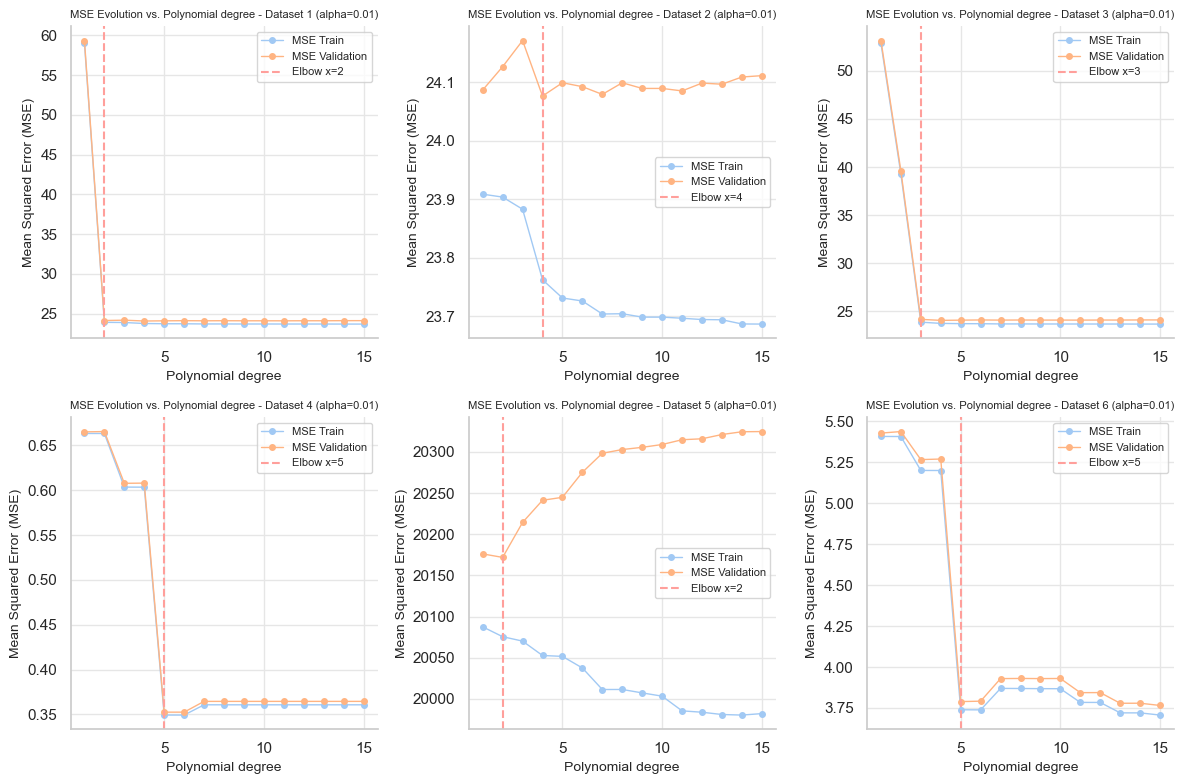

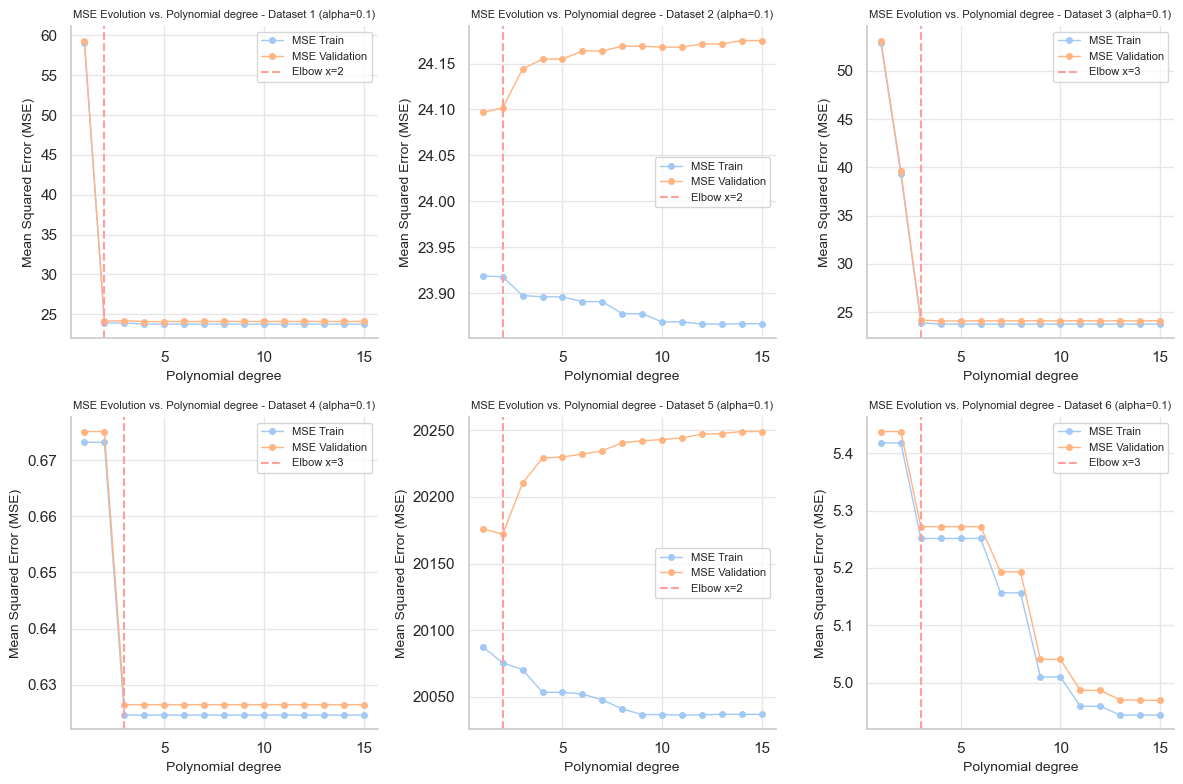

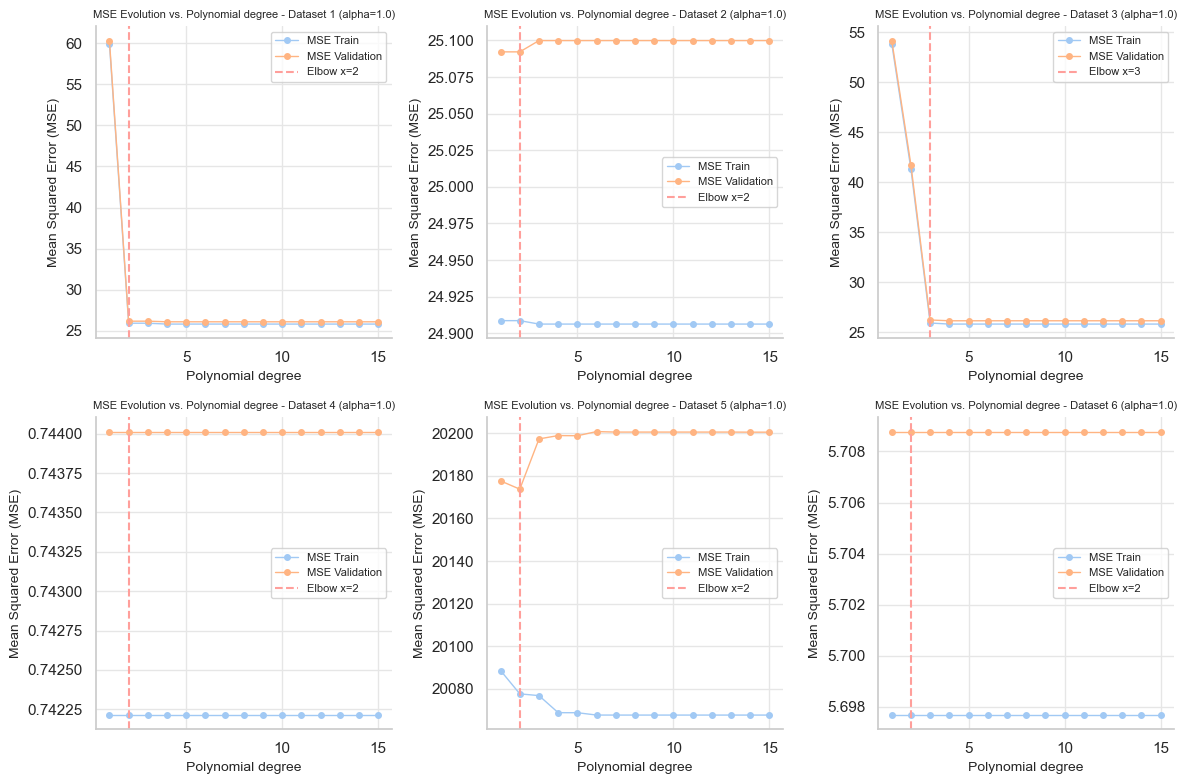

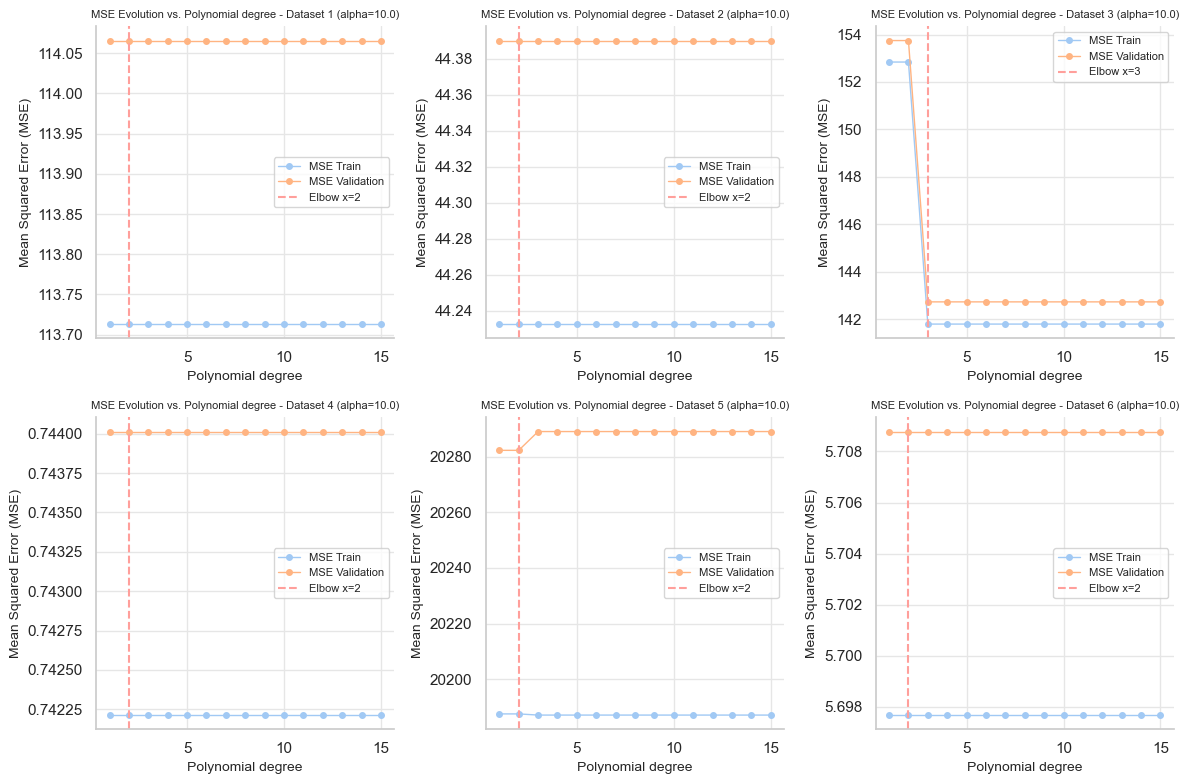

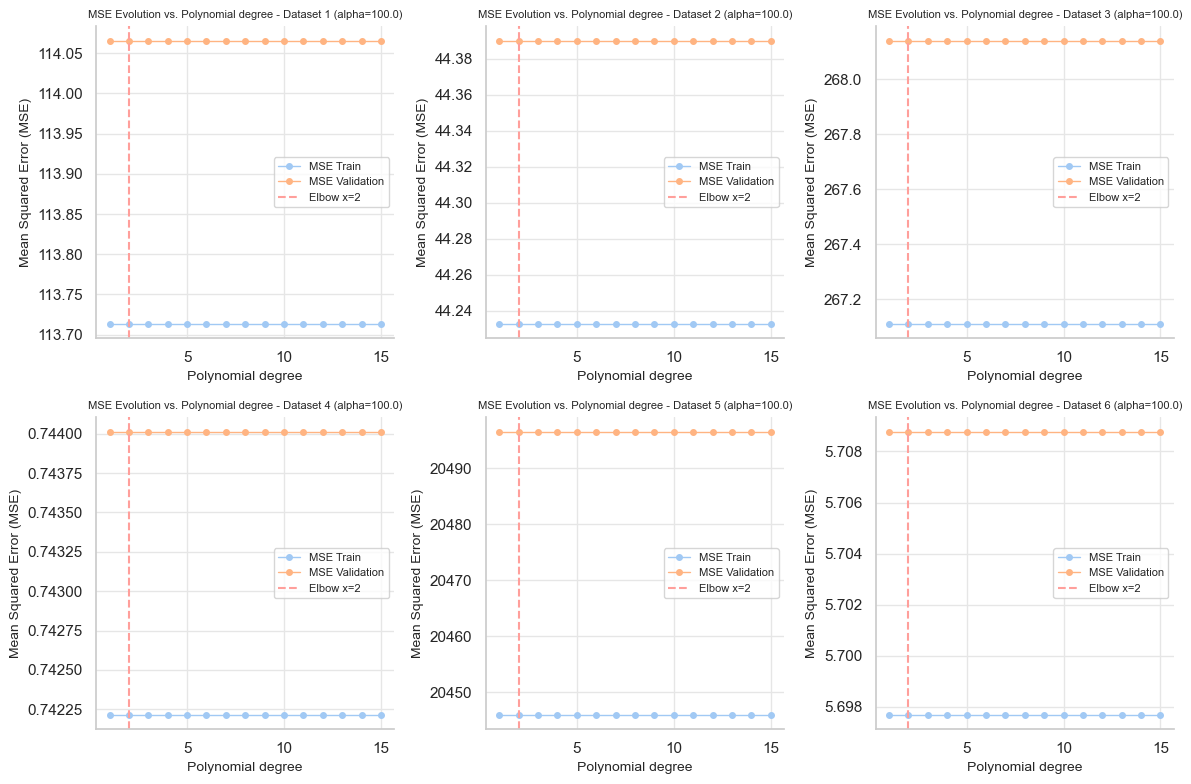

In [29]:
for alpha in alphas:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

    axes = axes.flatten()

    for i, (ax, dataset) in enumerate(zip(axes, mse_per_dataset_dict_l1)):
        ax.plot(
            degrees,  # Degrees
            mse_per_dataset_dict_l1[dataset]["mse_train"][alpha],
            marker="o",
            label="MSE Train",
            linewidth=1,  # Grosor de la curva
            markersize=4,  # Tamaño del marker
        )
        ax.plot(
            degrees,  # Degrees
            mse_per_dataset_dict_l1[dataset]["mse_valid"][alpha],
            marker="o",
            label="MSE Validation",
            linewidth=1,  # Grosor de la curva
            markersize=4,  # Tamaño del marker
        )
        validation_mse = mse_per_dataset_dict_l1[dataset]["mse_valid"][alpha]
        degree_min_mse = np.argmin(validation_mse) + 1

        # Método de la segunda derivada para encontrar el punto de codo
        second_derivative = np.diff(validation_mse, n=2)
        elbow_point = (
            np.argmax(second_derivative) + 2
        )  # +2 porque np.diff reduce el tamaño del array original en 2

        ax.axvline(
            x=elbow_point, color="r", linestyle="--", label=f"Elbow x={elbow_point}"
        )
        ax.set_xlabel("Polynomial degree", fontsize=10)  # Tamaño de la fuente
        ax.set_ylabel("Mean Squared Error (MSE)", fontsize=10)  # Tamaño de la fuente
        ax.set_title(
            f"MSE Evolution vs. Polynomial degree - Dataset {i + 1} (alpha={alpha})",
            fontsize=8,  # Tamaño de la fuente del título
        )
        ax.legend(fontsize=8)  # Tamaño de la fuente de la leyenda

    sns.despine()

    plt.tight_layout()
    plt.show()

In [36]:
def plot_mse_per_alpha_curves(mse_per_dataset_dict: dict[str, dict[str, list[float]]], dataset_name: str):
    # Dataset selection
    dataset = mse_per_dataset_dict_l1[dataset_name]

    # Viridis color list
    colors = px.colors.qualitative.Plotly

    fig = go.Figure()

    for alpha, color in zip(alphas, colors):
        # Training curve: solid line
        fig.add_trace(
            go.Scatter(
                x=degrees,
                y=dataset["mse_train"][alpha],
                mode="lines",
                line=dict(color=color, dash="solid"),
                name=f"alpha {alpha} train",
            )
        )

        # Validation curve: dashed line
        fig.add_trace(
            go.Scatter(
                x=degrees,
                y=dataset["mse_valid"][alpha],
                mode="lines",
                line=dict(color=color, dash="dash"),
                name=f"alpha {alpha} valid",
            )
        )

    fig.update_layout(
        title="MSE Curves (Train vs Valid) for different alpha values",
        xaxis_title="Degrees",
        yaxis_title="MSE",
        width=800,
        height=600,
    )

    fig.show()

In [38]:
for dataset in mse_per_dataset_dict_l1:
    plot_mse_per_alpha_curves(mse_per_dataset_dict_l1, dataset)

#### Ridge

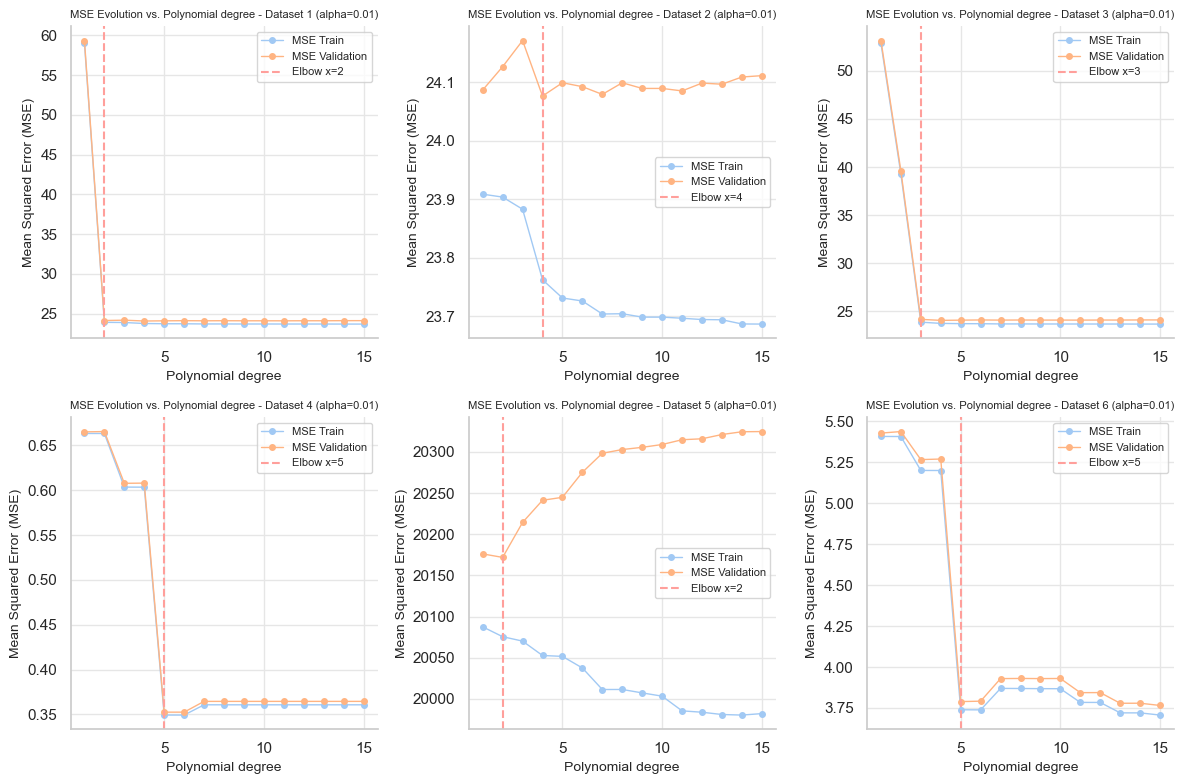

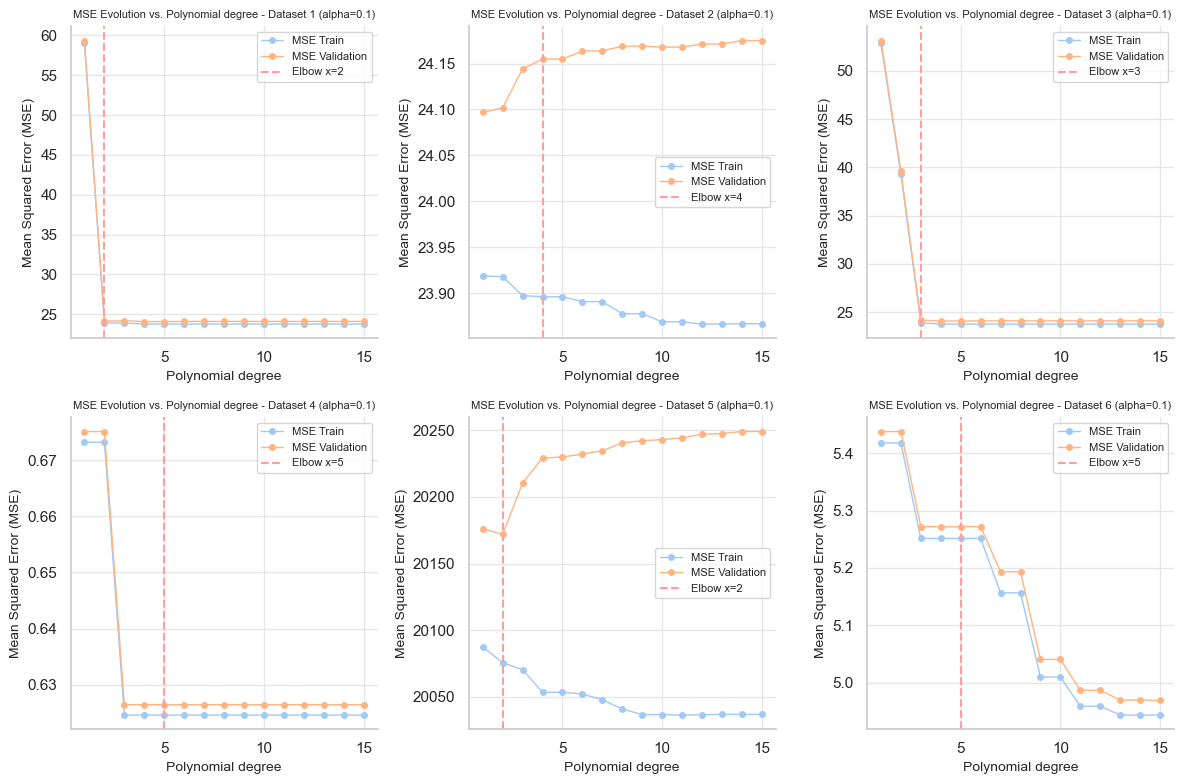

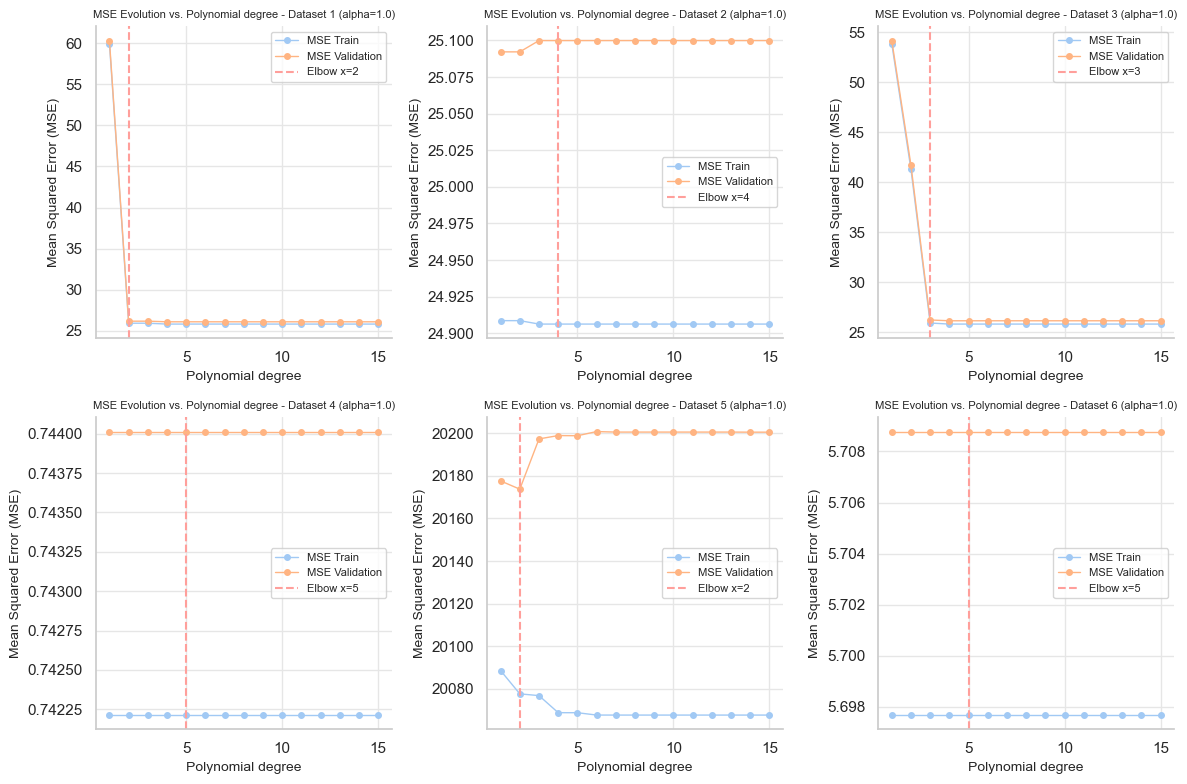

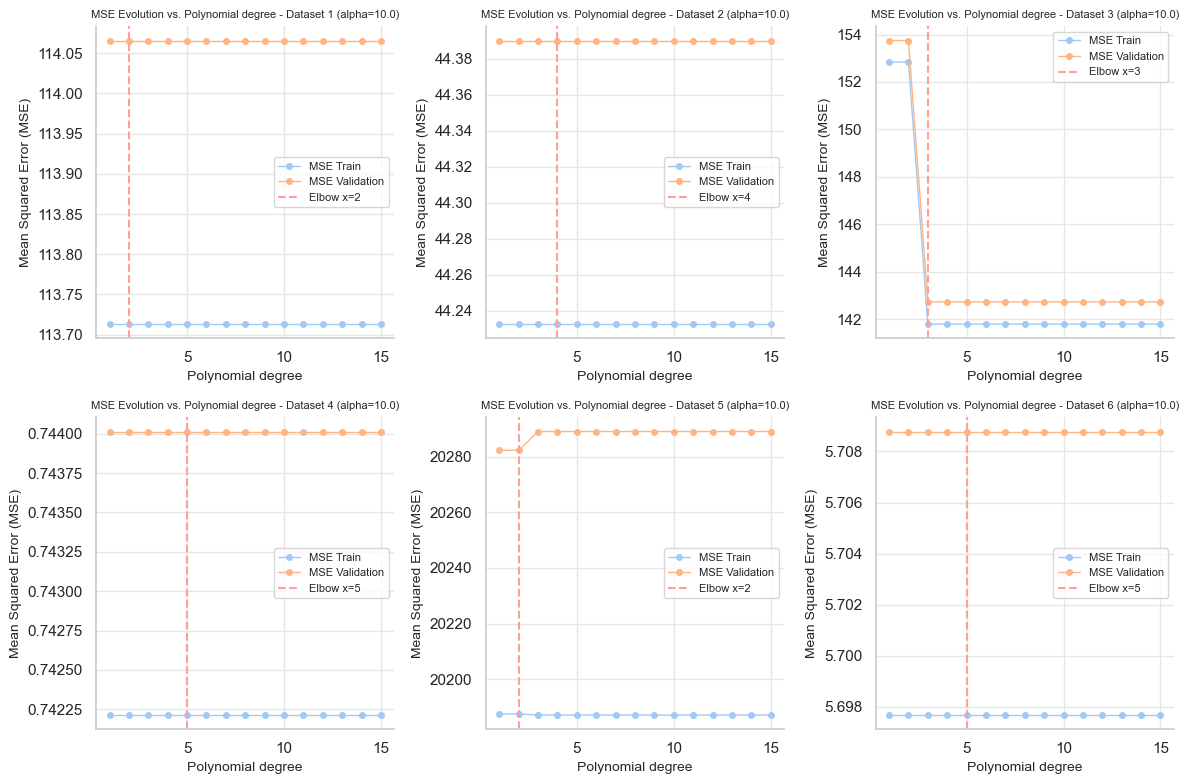

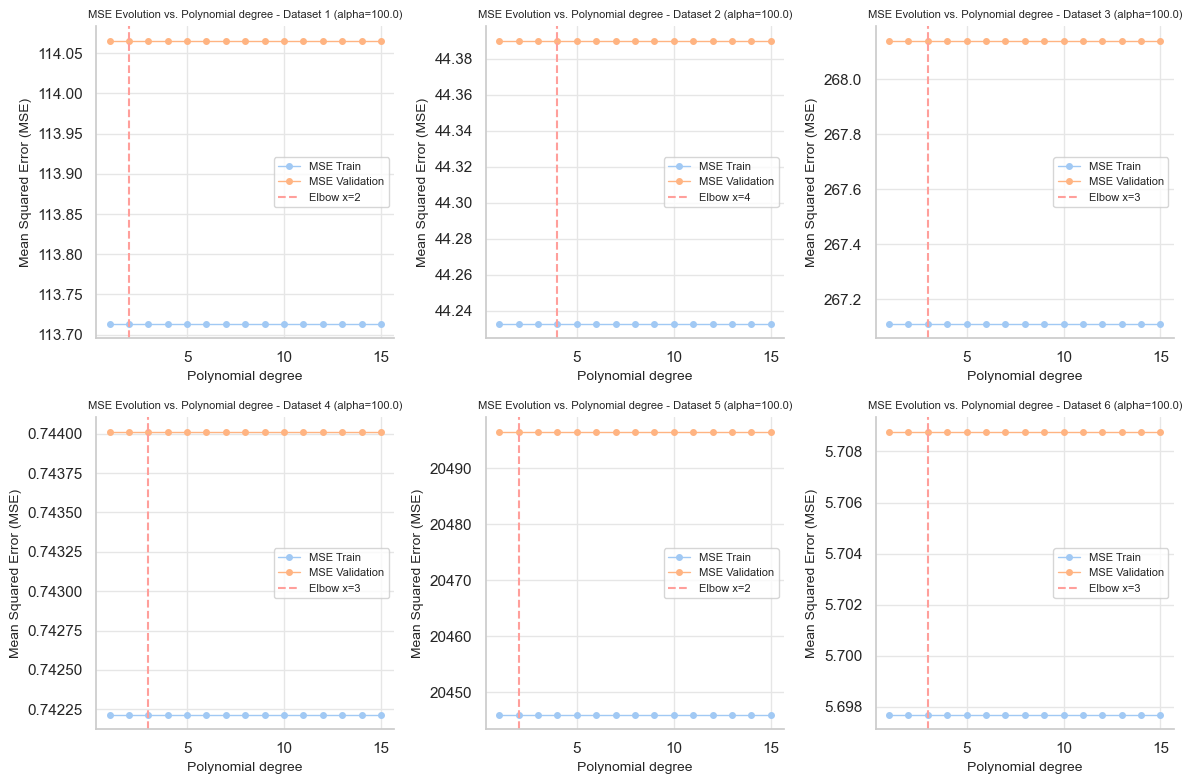

In [10]:
for alpha in alphas:
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

    axes = axes.flatten()

    for i, (ax, dataset) in enumerate(zip(axes, mse_per_dataset_dict_l2)):
        ax.plot(
            degrees,  # Degrees
            mse_per_dataset_dict_l1[dataset]["mse_train"][alpha],
            marker="o",
            label="MSE Train",
            linewidth=1,  # Grosor de la curva
            markersize=4,  # Tamaño del marker
        )
        ax.plot(
            degrees,  # Degrees
            mse_per_dataset_dict_l1[dataset]["mse_valid"][alpha],
            marker="o",
            label="MSE Validation",
            linewidth=1,  # Grosor de la curva
            markersize=4,  # Tamaño del marker
        )
        validation_mse = mse_per_dataset_dict_l2[dataset]["mse_valid"][alpha]
        degree_min_mse = np.argmin(validation_mse) + 1

        # Método de la segunda derivada para encontrar el punto de codo
        second_derivative = np.diff(validation_mse, n=2)
        elbow_point = (
            np.argmax(second_derivative) + 2
        )  # +2 porque np.diff reduce el tamaño del array original en 2

        ax.axvline(
            x=elbow_point, color="r", linestyle="--", label=f"Elbow x={elbow_point}"
        )
        ax.set_xlabel("Polynomial degree", fontsize=10)  # Tamaño de la fuente
        ax.set_ylabel("Mean Squared Error (MSE)", fontsize=10)  # Tamaño de la fuente
        ax.set_title(
            f"MSE Evolution vs. Polynomial degree - Dataset {i + 1} (alpha={alpha})",
            fontsize=8,  # Tamaño de la fuente del título
        )
        ax.legend(fontsize=8)  # Tamaño de la fuente de la leyenda

    sns.despine()

    plt.tight_layout()
    plt.show()

In [40]:
for dataset in mse_per_dataset_dict_l2:
    plot_mse_per_alpha_curves(mse_per_dataset_dict_l2, dataset)

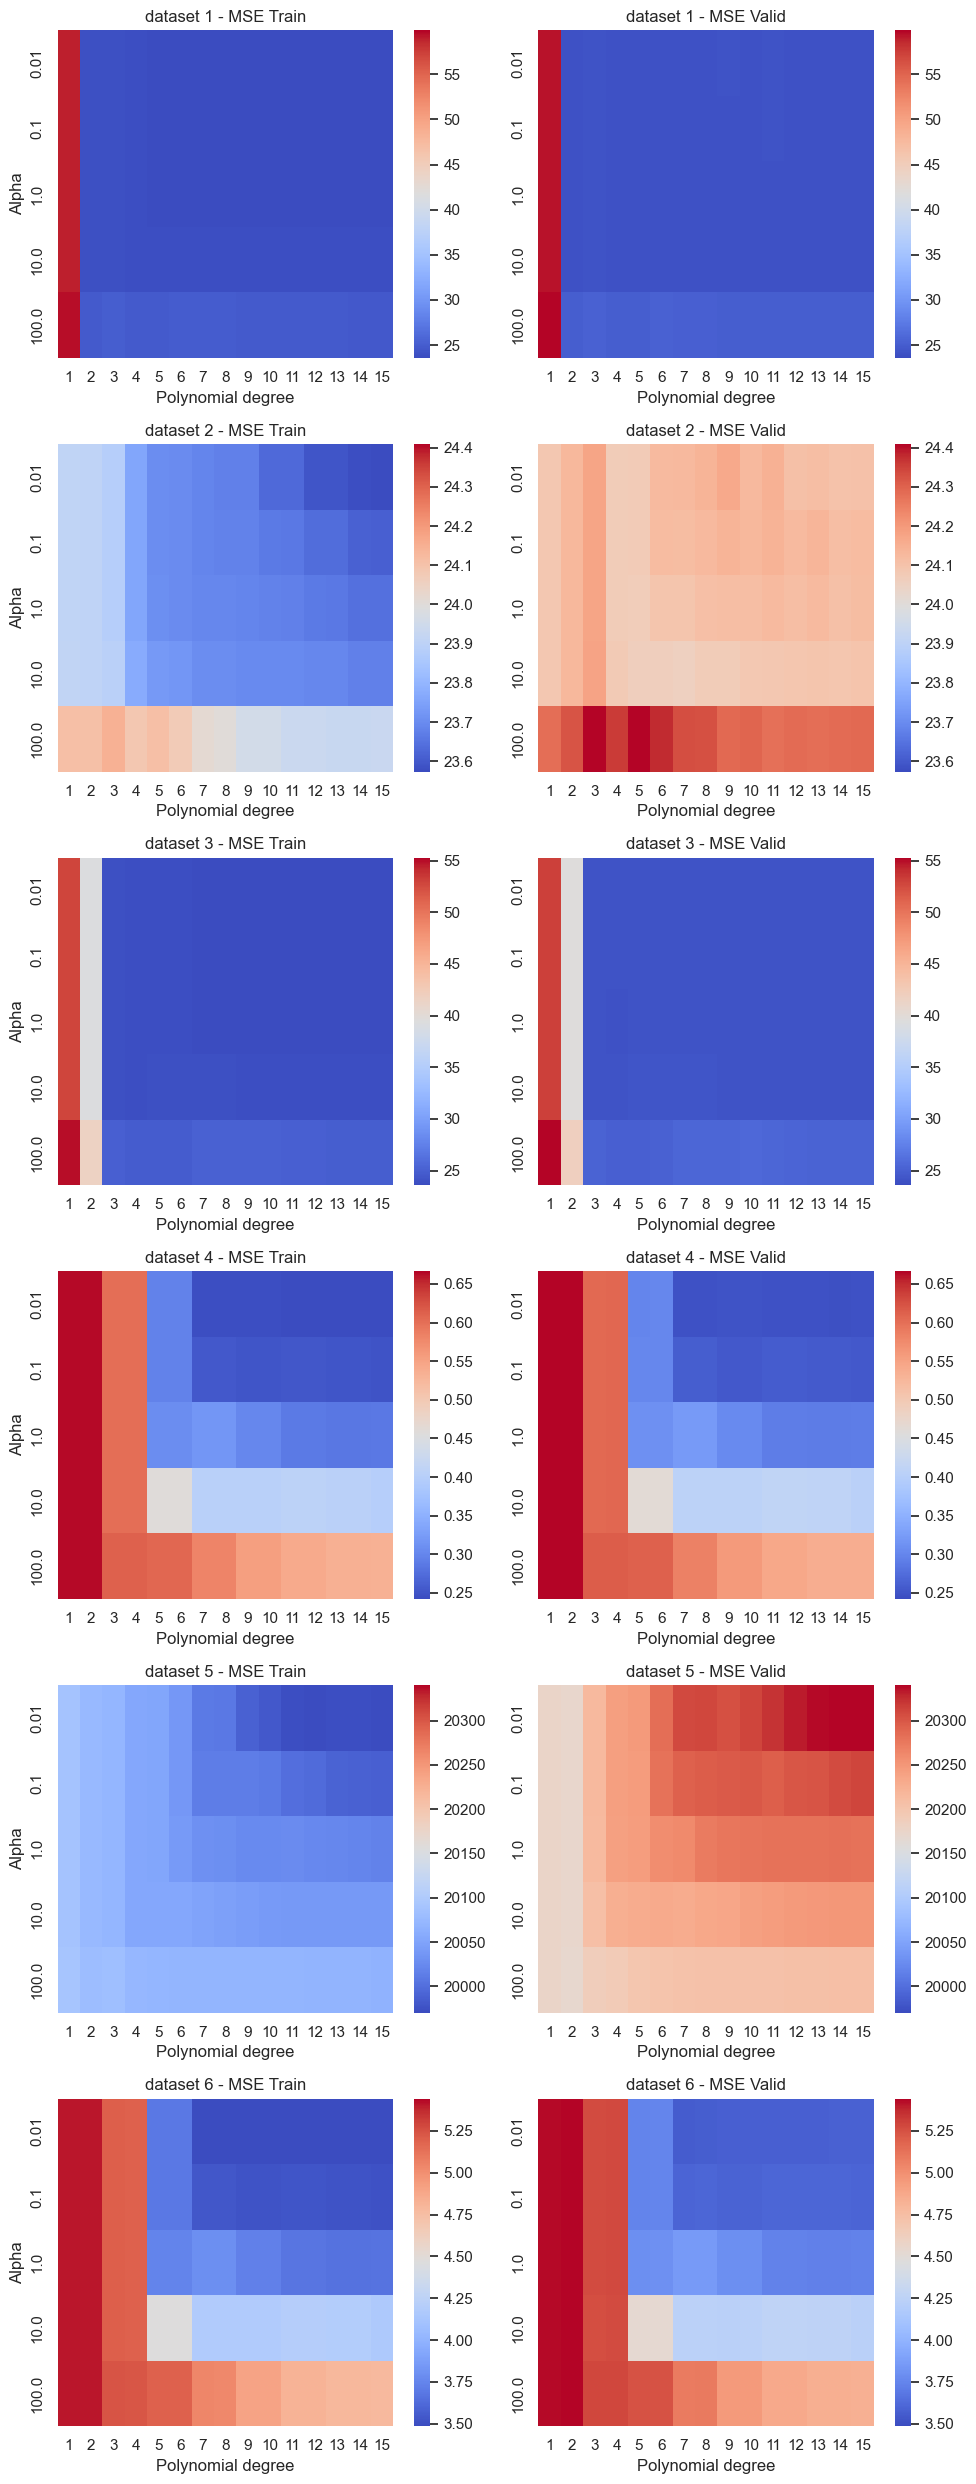

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

degrees = list(range(1, 16))

# Creamos la figura con 6 filas (uno por dataset) y 2 columnas (Train vs. Valid)
fig, axes = plt.subplots(nrows=len(datasets), ncols=2, figsize=(10, 25))

for row_idx, dataset in enumerate(datasets):
    # Extraer el diccionario del dataset
    data = dataset.copy()

    # Construir matrices para Train y Valid
    # Filas: cada alpha
    # Columnas: cada grado (1..15)
    mse_train = []
    mse_valid = []

    for alpha in alphas:
        # Cada lista de MSE para un alpha dado corresponde a grados 1..15
        train_values = mse_per_dataset_dict_l2[f"dataset_{row_idx + 1}"]["mse_train"][
            alpha
        ]  # lista de 15 valores
        valid_values = mse_per_dataset_dict_l2[f"dataset_{row_idx + 1}"]["mse_valid"][
            alpha
        ]  # lista de 15 valores

        mse_train.append(train_values)
        mse_valid.append(valid_values)

    # Convertir a arrays NumPy
    mse_train = np.array(mse_train)  # shape: (5, 15)
    mse_valid = np.array(mse_valid)  # shape: (5, 15)

    # Para que Train y Valid usen la misma escala de color,
    # calculamos el min y max conjunto (dentro de este dataset)
    vmin_val = min(mse_train.min(), mse_valid.min())
    vmax_val = max(mse_train.max(), mse_valid.max())

    # --- Heatmap de entrenamiento ---
    ax_train = axes[row_idx, 0]
    sns.heatmap(
        mse_train,
        ax=ax_train,
        cmap="coolwarm",
        xticklabels=degrees,  # grados en eje X
        yticklabels=alphas,  # alpha en eje Y
        annot=False,  # muestra los valores en la celda
        fmt=".2f",  # formato numérico
        cbar=True,
        vmin=vmin_val,
        vmax=vmax_val,
    )
    ax_train.set_title(f"dataset {row_idx + 1} - MSE Train")
    ax_train.set_xlabel("Polynomial degree")
    ax_train.set_ylabel("Alpha")

    # --- Heatmap de validación ---
    ax_valid = axes[row_idx, 1]
    sns.heatmap(
        mse_valid,
        ax=ax_valid,
        cmap="coolwarm",
        xticklabels=degrees,
        yticklabels=alphas,
        annot=False,
        fmt=".2f",
        cbar=True,
        vmin=vmin_val,
        vmax=vmax_val,
    )
    ax_valid.set_title(f"dataset {row_idx + 1} - MSE Valid")
    ax_valid.set_xlabel("Polynomial degree")
    # Para evitar que se repita la etiqueta "Alpha" en la derecha
    ax_valid.set_ylabel("")

# Ajustar espaciados
plt.tight_layout()
plt.show()

A partir del punto de codo se puede determinar el grado polinómico óptimo que evita que, al aumentar la complejidad del modelo más allá de ese punto, la reducción del error deje de ser significativa y el error de validación comience a aumentar. Esto indica que el modelo está sobre-aprendiendo; reduciendo su capacidad de generalización para el conjunto de validación.

En otras palabras, el sesgo se reduce mientras que la varianza comienza a aumentar.

En la imagen superior, se puede ver el grado óptimo de la regresión polinómica marcado con una recta roja discontinua.

Los grados óptimos serían:
- **dataset_1**: `2`
- **dataset_2**: `4` (En este caso, dada la forma que presenta el error de validación, el punto codo no es efectivo para determinar el grado. En este caso el grado a escoger debe ser el que menor error de validación presente)
- **dataset_3**: `3`
- **dataset_4**: `5`
- **dataset_5**: `2`
- **dataset_6**: `5`

#### **Sesgo vs. Varianza**

El **sesgo** consiste en el error que se introduce cuando el modelo es demasiado simple y no tiene la capacidad para representar completamente todas las relaciones entre los datos. Esto se observa cuando ambos errores de entrenamiento y de validación son altos.

La **varianza** consiste en el error debido a un modelo sensible a las fluctuaciones de los datos. En estos casos, dado que el modelo se entrena con el conjunto de entrenamiento, este captura muy bien las variaciones en las relaciones de este mismo conjunto, sin embargo, no es igual de bueno con el conjunto de validación. Esto se observa cuando el error del conjunto de entrenamiento es muy bajo frente al error de validación

### Plotting the estimated function

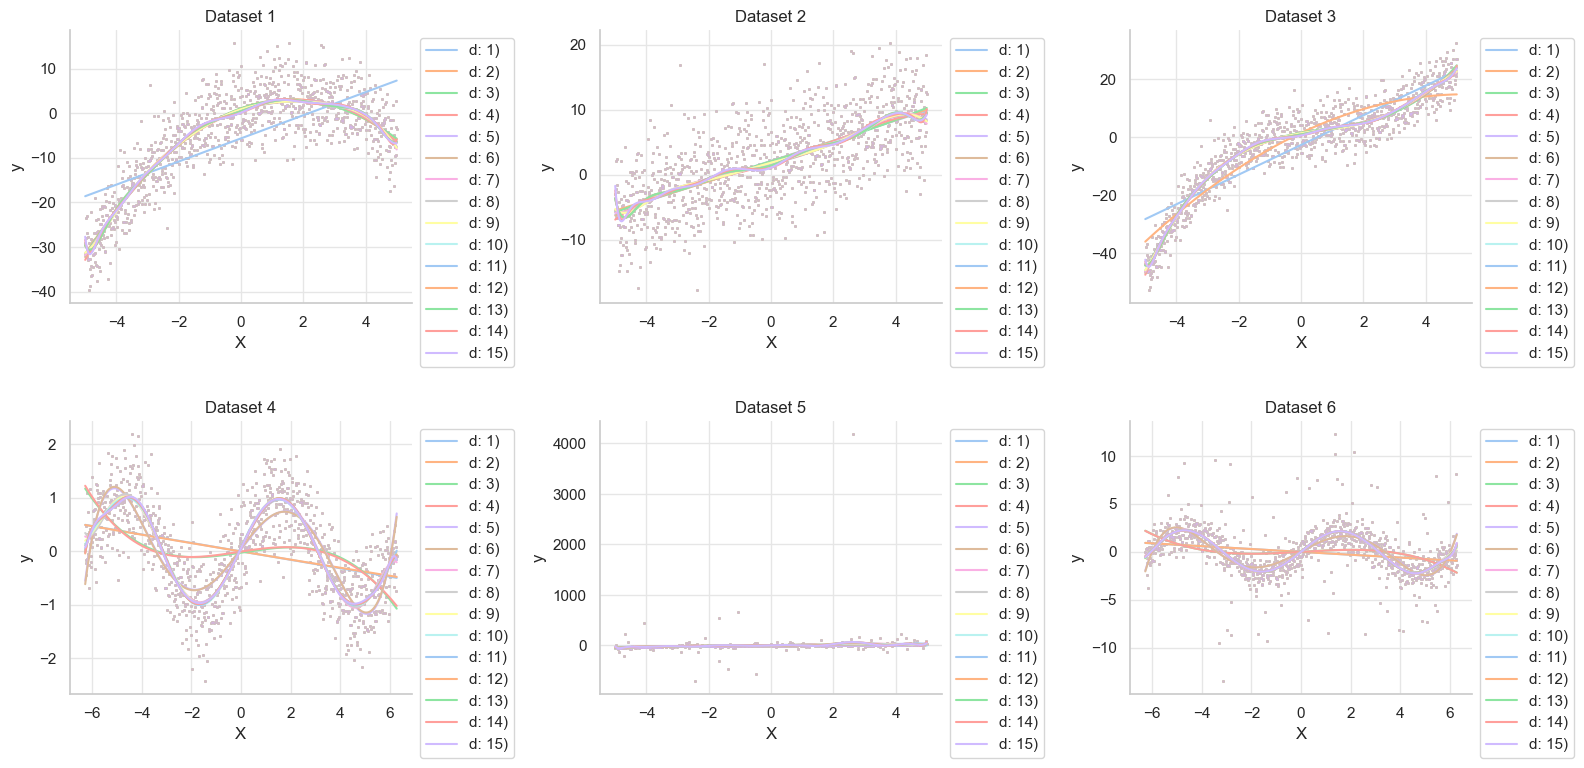

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

axes = axes.flatten()

for i, (ax, dataset) in enumerate(zip(axes, mse_per_dataset_dict)):
    dataset_x = datasets[i][["X"]]
    for d, model in enumerate(mse_per_dataset_dict[dataset]["model"]):
        y_pred = model.predict(
            PolynomialFeatures(degree=d + 1).fit_transform(dataset_x)
        )
        ax.plot(dataset_x, y_pred, label=f"d: {d + 1})")
        ax.scatter(dataset_x, datasets[i]["y"], alpha=0.3, s=1)
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.set_title(f"Dataset {i + 1}")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

sns.despine()

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.tight_layout()
plt.show()

En esta gráfica se puede observar, para cada dataset, la forma de las funciones estimadas porla regresión polinómica para cada grado. Por ejemplo en el `dataset_1` se puede observar como la función de grado 1 es una recta, la de grado 2 es una curva, y a medida que aumentan los grados, la curva intenta adaptarse más al conjunto de datos. esto también se observa claramente en los `dataset_4` y `dataset_6`

## EXTRA

In [ ]:
def coef_and_p_values_datasets(
    mse_per_dataset_dict: dict[str, dict[str, list[float]]],
) -> list[pd.DataFrame]:
    """Create a DataFrame with the degrees, coefficients and p-values for each dataset.

    Parameters
    ----------
    mse_per_dataset_dict : dict[str, dict[str, list[float]]]
        Dictionary with the mean squared error for the training and validation sets
        for each dataset and degree and the model with the lowest validation error.

    Returns
    -------
    list[pd.DataFrame]
        List with the DataFrames for each dataset with the degrees,
        coefficients and p-values.
    """
    params_tables = []
    for dataset in mse_per_dataset_dict:
        degrees = range(1, 16)

        coefs_by_degree_list = []
        pvalues_by_degree_list = []
        for d in degrees:
            # Coefficients
            # d-1 because range(1, 16) sarts in 1
            coefs = mse_per_dataset_dict[dataset]["model"][d - 1].params.values
            # coefs = ' , '.join([f'{coef}' for coef in coefs])
            coefs_by_degree_list.append(coefs)

            # P-Values
            pvalues = mse_per_dataset_dict[dataset]["model"][d - 1].pvalues.values
            # pvalues = ' , '.join([f'{p}' for p in pvalues])
            pvalues_by_degree_list.append(pvalues)

        params_tables.append(
            pd.DataFrame(
                {
                    "Grado": degrees,
                    "Coeficientes": coefs_by_degree_list,
                    "p_values": pvalues_by_degree_list,
                    "mean_p_values": [np.mean(pval) for pval in pvalues_by_degree_list],
                }
            )
        )
    return params_tables

In [ ]:
params_tables = coef_and_p_values_datasets(mse_per_dataset_dict=mse_per_dataset_dict)

#### Evolución de la significancia de los coeficientes conforme aumenta la complejidad del modelo

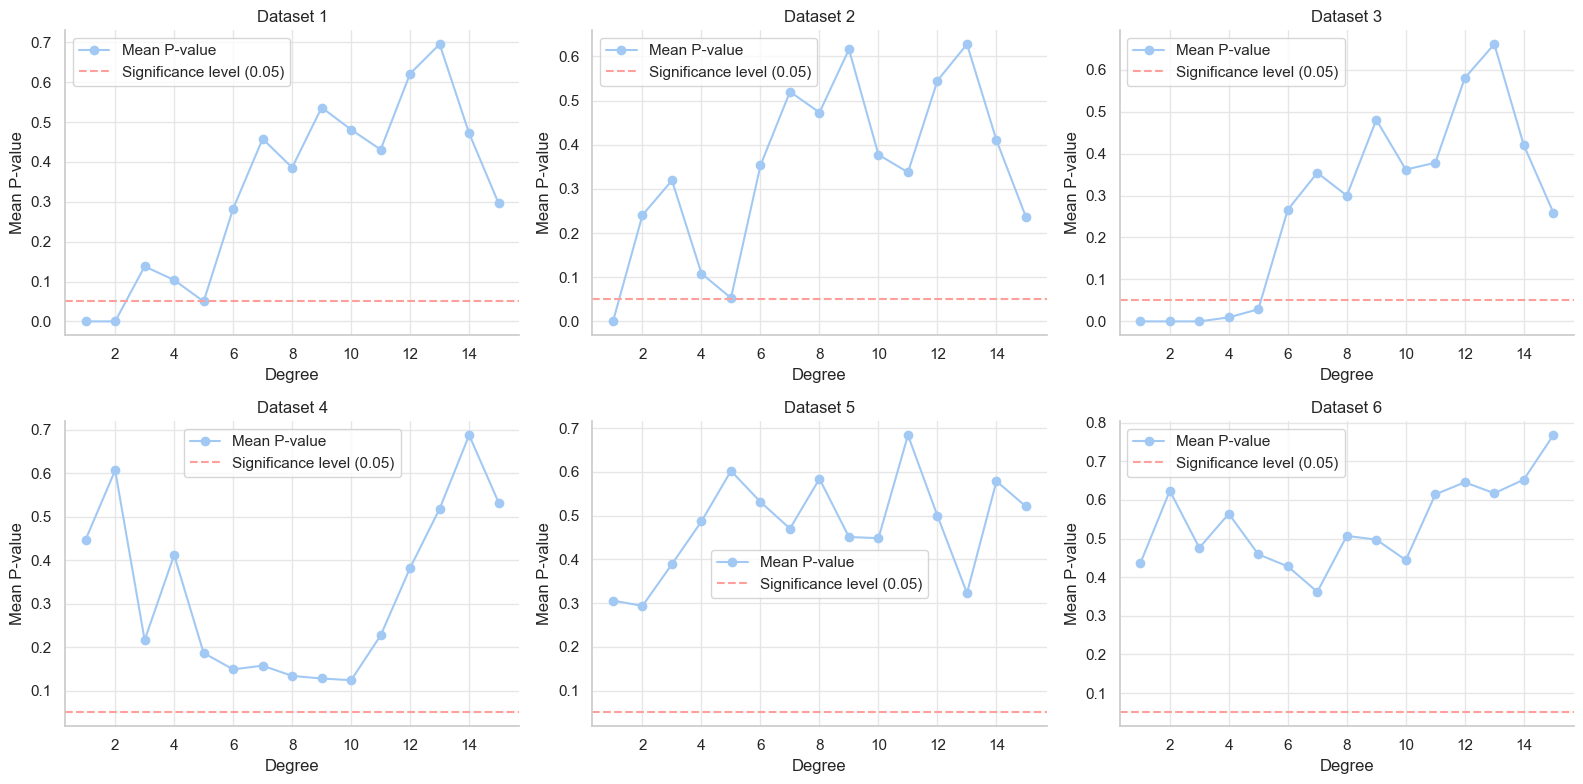

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

axes = axes.flatten()

for i, (ax, dataset) in enumerate(zip(axes, params_tables)):
    ax.plot(
        dataset["Grado"],
        dataset["mean_p_values"],
        marker="o",
        label="Mean P-value",
    )

    ax.set_xlabel("Degree")
    ax.set_ylabel("Mean P-value")
    ax.set_title(f"Dataset {i + 1}")

    ax.axhline(y=0.05, color="r", linestyle="--", label="Significance level (0.05)")
    ax.legend()

# Remove the top and right spines from plot(s)
sns.despine()

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.tight_layout()
plt.show()

Por lo que se puede observar en las gráficas de evolución, el P-valor medio de los coeficientes tiende aumentar; en otras palabras, la significancia del modelo cada vez es menor, por lo que su capacidad explicativa se ve mermada a medida que la complejidad aumenta.

Los grados en los que el P-valor medio es menor (coeficientes más significativo) y por lo tanto, están por debajo del nivel de significancia del 5% (un nivel de confianza del 95%) son:
- **dataset_1**: `2`
- **dataset_2**: `1`
- **dataset_3**: `2`, `3`
- **dataset_4**: Ninguno consigue un P-valor menor que el 5%. El grado con menor P-valor es el 10. Esto nos indica que no hay clara significancia estadística de los coeficientes polinómicos adicionales.
- **dataset_5**: Ninguno consigue un P-valor menor que el 5%. El grado con menor P-valor es el 2. Esto nos indica que no hay clara significancia estadística de los coeficientes polinómicos adicionales.
- **dataset_6**: Ninguno consigue un P-valor menor que el 5%. El grado con menor P-valor es el 7. Esto nos indica que no hay clara significancia estadística de los coeficientes polinómicos adicionales.

El hecho de que algunos grados mejoren el error de validación teniendo sin embargo p-values altos se debe a que, desde un punto de vista predictivo, lo buscado es una buena capacidad de generalización, sin embargo, en polinomios puede darse mucha multicolinealidad, por lo que la significancia estadística se ve reducida. Es decir, a mayor número de grados (complejidad), hay mayor presencia de términos redundantes que inflará el valor promedio de los p-valores.

El modelo con un grado óptimo no solo minimiza el error de validación, sino que además presenta coeficientes en su mayoría significativos, lo que respalda su capacidad explicativa. Sin embargo, a la hora de tomar una decisión es necesario conocer el objetivo; si el objetivo es interpretativo, priorizar grados donde la significancia estadística de los coeficientes sea alta, y si el objetivo es predictivo, priorizar grados con un error del conjunto de validación reducido.